In [1]:
import numpy as np
from scipy.interpolate import interp1d as interp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from src.thunderflask import thunderflask
from src.bacteria import strain
from src.ffgen import ffgen
from src.redGen import reductionist
from src.codonTable import codonTable
from src.codonUtils import utils
from src.bacteria import strain
import pickle
from src.codonOptimizer import tableOptimizer
from queue import Queue as queue
from random import choice
from matplotlib.colors import LinearSegmentedColormap as LSC
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import cProfile
import copy
import random

In [2]:
rc = utils.standardTable
#Break table into dictionaries for each amino acid
Fblock = dict((key,value) for key, value in rc.items() if value == 'F')
Lblock = dict((key,value) for key, value in rc.items() if value == 'L')
Sblock = dict((key,value) for key, value in rc.items() if value == 'S')
Yblock = dict((key,value) for key, value in rc.items() if value == 'Y')
Cblock = dict((key,value) for key, value in rc.items() if value == 'C')
Wblock = dict((key,value) for key, value in rc.items() if value == 'W')
Pblock = dict((key,value) for key, value in rc.items() if value == 'P')
Hblock = dict((key,value) for key, value in rc.items() if value == 'H')
Qblock = dict((key,value) for key, value in rc.items() if value == 'Q')
Rblock = dict((key,value) for key, value in rc.items() if value == 'R')
Iblock = dict((key,value) for key, value in rc.items() if value == 'I')
Mblock = dict((key,value) for key, value in rc.items() if value == 'M')
Tblock = dict((key,value) for key, value in rc.items() if value == 'T')
Vblock = dict((key,value) for key, value in rc.items() if value == 'V')
Nblock = dict((key,value) for key, value in rc.items() if value == 'N')
Ablock = dict((key,value) for key, value in rc.items() if value == 'A')
Dblock = dict((key,value) for key, value in rc.items() if value == 'D')
Eblock = dict((key,value) for key, value in rc.items() if value == 'E')
Gblock = dict((key,value) for key, value in rc.items() if value == 'G')
Kblock = dict((key,value) for key, value in rc.items() if value == 'K')
stopBlock = dict((key,value) for key, value in rc.items() if value == '*')
blockArray = [Fblock, Lblock, Sblock, Yblock, Cblock, Wblock, Pblock, Hblock, Qblock, Rblock,
                Iblock, Mblock, Tblock, Vblock, Nblock, Ablock, Dblock, Eblock, Gblock, Kblock, stopBlock]
        
#Iterate through all amino acid blocks selecting one key and setting the rest map to stop 
choices = ['UUU','UCC','UAA','UGG','CUC','CCA','CAG','CGU','AUA','ACG','AAU','AGC','GUG','GCU','GAC','GGA']
choices2 = []
for i in range (len(blockArray)):
    choices2.append(random.choice(list(blockArray[i])))
    for key in blockArray[i]: 
        if key not in choices:
            blockArray[i][key] = '*'
reductionistTable = {}
for i in range (len(blockArray)):
    reductionistTable.update(blockArray[i])
# return built table
# Fix AGC and UAA miswrite
reductionistTable['AGC'] = 'C'
reductionistTable['UAA'] = 'M'
reductionistTable['UUG'] = 'Y'
reductionistTable['CCC'] = 'H'
reductionistTable['GAU'] = 'E'
reductionistTable['AGA'] = 'K'

In [3]:
ffTable = codonTable(reductionistTable)

In [4]:
ffTable.dictToTable()

U        C        A        G
U U  UUU : F  UCU : *  UAU : *  UGU : *
  C  UUC : *  UCC : S  UAC : *  UGC : *
  A  UUA : *  UCA : *  UAA : M  UGA : *
  G  UUG : Y  UCG : *  UAG : *  UGG : W
C U  CUU : *  CCU : *  CAU : *  CGU : R
  C  CUC : L  CCC : H  CAC : *  CGC : *
  A  CUA : *  CCA : P  CAA : *  CGA : *
  G  CUG : *  CCG : *  CAG : Q  CGG : *
A U  AUU : *  ACU : *  AAU : N  AGU : *
  C  AUC : *  ACC : *  AAC : *  AGC : C
  A  AUA : I  ACA : *  AAA : *  AGA : K
  G  AUG : *  ACG : T  AAG : *  AGG : *
G U  GUU : *  GCU : A  GAU : E  GGU : *
  C  GUC : *  GCC : *  GAC : D  GGC : *
  A  GUA : *  GCA : *  GAA : *  GGA : G
  G  GUG : V  GCG : *  GAG : *  GGG : *

A Jupyter Widget

/anaconda3/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


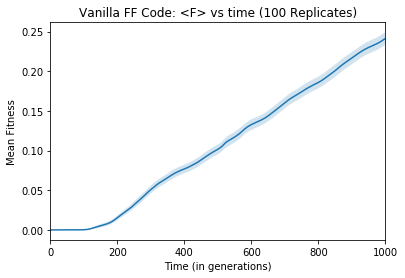

done


In [6]:
# initialize some variables
T_curr = 0
mut_param = [1,2]
dt = 0.1
N_sims = 100
T_sim = 1000
t_extra = 5
date = '3-6'
code = 'Vanilla FF Code'
filepath = 'res/manuscript_traces'
filename = '{0}_{1}_favg_traces_T={2}_N={3}_b={4}_l={5}.pickle'.format(date,
                                                                       code,
                                                                       T_sim,
                                                                       N_sims,
                                                                      mut_param[0],
                                                                      mut_param[1]) 
# initialize list of dictionaries of arrays (i know, it's too much) 
dataframes = []
newtimes = np.linspace(0, T_sim, int((T_sim)/dt))
# run N simulations
for i in tqdm_notebook(range(N_sims), desc='Simulation Number: '):
    LUCA = strain(N_pop=1e6, table=ffTable, fitness=0, mu=2e-5)
    sim = thunderflask(LUCA)
    sim.simulate(T_sim+t_extra, dt, T_curr, mut_param, show_progress=False)
    t = sim.f_avgtrace['timepoints']
    f_avg = sim.f_avgtrace['f_avg']
    interp_fxn = interp(t, f_avg)
    newf = interp_fxn(newtimes)
    df = pd.DataFrame({
        'time' : newtimes, 
        'value' : newf, 
        'sim' : [i for j in range(len(newf))],
        'code' : [code for j in range(len(newf))]
    })
    dataframes.append(df)
# package data into pandas dataframe
df_sc = pd.concat(dataframes)
# pickle results
with open('{0}/{1}'.format(filepath, filename), 'wb') as handle:
    pickle.dump(df_sc, handle)
# plot results
ax = sns.tsplot(data=df_sc, time='time', value='value', unit='sim')
plt.title('{0}: <F> vs time ({1} Replicates)'.format(code, N_sims))
plt.xlabel('Time (in generations)')
plt.ylabel('Mean Fitness')
plt.show()
print('done')